# Проект «Работа с заботой»


Данный проект получил на вход две задачи:

1. Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
2. Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Основная цель: Формирование более предиктивного понимания причины увольнения сотрудников; формирование портрета человека, написавшего по собственному; построение работающих моделей прогнозирования уровня удовлетворенностью работой, а так же предсказания скорейшего увольнения.

# Задача 1: предсказание уровня удовлетворённости сотрудника

## Импорт данных

In [1]:
!pip install optuna -q # -q убирает необязательные выводы в командах Linux
!pip install shap -q
!pip install -U scikit-learn  -q

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, mean_absolute_error, make_scorer
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from optuna.integration import OptunaSearchCV 
import optuna
import shap

In [3]:
df_train = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
df_test_feature = pd.read_csv('/datasets/test_features.csv')
df_test_target = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

In [4]:
def info (df):
    print(df.head())
    print(df.describe())
    df.info()

In [5]:
info(df_train)

       id        dept   level workload  employment_years last_year_promo  \
0  155278       sales  junior   medium                 2              no   
1  653870          hr  junior     high                 2              no   
2  184592       sales  junior      low                 1              no   
3  171431  technology  junior      low                 4              no   
4  693419          hr  junior   medium                 1              no   

  last_year_violations  supervisor_evaluation  salary  job_satisfaction_rate  
0                   no                      1   24000                   0.58  
1                   no                      5   38400                   0.76  
2                   no                      2   12000                   0.11  
3                   no                      2   18000                   0.37  
4                   no                      3   22800                   0.20  
                  id  employment_years  supervisor_evaluation        

In [6]:
info(df_test_feature)

       id       dept   level workload  employment_years last_year_promo  \
0  485046  marketing  junior   medium                 2              no   
1  686555         hr  junior   medium                 1              no   
2  467458      sales  middle      low                 5              no   
3  418655      sales  middle      low                 6              no   
4  789145         hr  middle   medium                 5              no   

  last_year_violations  supervisor_evaluation  salary  
0                   no                      5   28800  
1                   no                      4   30000  
2                   no                      4   19200  
3                   no                      4   19200  
4                   no                      5   40800  
                  id  employment_years  supervisor_evaluation        salary
count    2000.000000       2000.000000            2000.000000   2000.000000
mean   552765.213500          3.666500               3.526500

In [7]:
info(df_test_target)

       id  job_satisfaction_rate
0  130604                   0.74
1  825977                   0.75
2  418490                   0.60
3  555320                   0.72
4  826430                   0.08
                  id  job_satisfaction_rate
count    2000.000000             2000.00000
mean   552765.213500                0.54878
std    253851.326129                0.22011
min    100298.000000                0.03000
25%    339052.000000                0.38000
50%    550793.000000                0.58000
75%    765763.750000                0.72000
max    999029.000000                1.00000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Выгрузили данные в датасеты и проверили первичный осмотр.

## Предобработка данных

Сразу подготовим функции для работы с данными

In [8]:
def columns_list (df):
    x = df.select_dtypes(include = ['int64', 'float64', 'object', 'category']).columns.to_list()
    return x

In [9]:
def column_quantity (df):
    x = df.select_dtypes(include = ['int64', 'float64']).columns.to_list()
    return x

In [10]:
def column_quality (df):
    x = df.select_dtypes(include = ['object']).columns.to_list()

In [11]:
def quantity_analysis (df):
    analysis = {}
    missing = df.isnull().sum()
    percent = (missing / len(df)) * 100
    analysis = pd.DataFrame({'quantity_missing': missing,
                                              'percent_missing': percent,
                            })
    analysis['duplicates'] = df.duplicated().sum()
    return analysis

In [12]:
def quality_analysis (df):
    columns = df.select_dtypes(include = ['object', 'category']).columns.to_list()
    for i in columns:
        print(f"{i}: {df[i].nunique()}"); print(df[i].unique())

In [13]:
print(quality_analysis(df_train))
quantity_analysis(df_train)

dept: 5
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
level: 3
['junior' 'middle' 'sinior' nan]
workload: 3
['medium' 'high' 'low']
last_year_promo: 2
['no' 'yes']
last_year_violations: 2
['no' 'yes']
None


,quantity_missing,percent_missing,duplicates
id,0,0.00,0
dept,6,0.15,0
level,4,0.10,0
workload,0,0.00,0
employment_years,0,0.00,0
last_year_promo,0,0.00,0
last_year_violations,0,0.00,0
supervisor_evaluation,0,0.00,0
salary,0,0.00,0
job_satisfaction_rate,0,0.00,0


In [14]:
print(quality_analysis(df_test_feature))
quantity_analysis(df_test_feature)

dept: 6
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level: 3
['junior' 'middle' 'sinior' nan]
workload: 4
['medium' 'low' 'high' ' ']
last_year_promo: 2
['no' 'yes']
last_year_violations: 2
['no' 'yes']
None


,quantity_missing,percent_missing,duplicates
id,0,0.00,0
dept,2,0.10,0
level,1,0.05,0
workload,0,0.00,0
employment_years,0,0.00,0
last_year_promo,0,0.00,0
last_year_violations,0,0.00,0
supervisor_evaluation,0,0.00,0
salary,0,0.00,0


In [15]:
print(quality_analysis(df_test_target))
quantity_analysis(df_test_target)

None


,quantity_missing,percent_missing,duplicates
id,0,0.0,0
job_satisfaction_rate,0,0.0,0


По итогам анализа состояния датафреймов были найдены некоторые проблемы:
1. Присутствие nan в признаках dept и level датафрейма df_train
2. Очепятка в категории 'sinior' признака level.
3. Аналогичные проблемы в df_tset_feature.
4. В df_feature_test так же имеются значения - пробелы ' ' в признаках dept и workload

Так как, в процентном соотношении, количество строк с пропусками не достигает и процента, можем избавиться от этих строк, не теряя качество данных.

In [16]:
df_test_feature[df_test_feature['workload'] == ' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800


In [17]:
df_train['level'] = df_train['level'].str.replace('sinior', 'senior')
df_test_feature['level'] = df_test_feature['level'].str.replace('sinior', 'senior')

In [18]:
print(quality_analysis(df_train))
quantity_analysis(df_train)

dept: 5
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
level: 3
['junior' 'middle' 'senior' nan]
workload: 3
['medium' 'high' 'low']
last_year_promo: 2
['no' 'yes']
last_year_violations: 2
['no' 'yes']
None


,quantity_missing,percent_missing,duplicates
id,0,0.00,0
dept,6,0.15,0
level,4,0.10,0
workload,0,0.00,0
employment_years,0,0.00,0
last_year_promo,0,0.00,0
last_year_violations,0,0.00,0
supervisor_evaluation,0,0.00,0
salary,0,0.00,0
job_satisfaction_rate,0,0.00,0


In [19]:
print(quality_analysis(df_test_feature))
quantity_analysis(df_test_feature)

dept: 6
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level: 3
['junior' 'middle' 'senior' nan]
workload: 4
['medium' 'low' 'high' ' ']
last_year_promo: 2
['no' 'yes']
last_year_violations: 2
['no' 'yes']
None


,quantity_missing,percent_missing,duplicates
id,0,0.00,0
dept,2,0.10,0
level,1,0.05,0
workload,0,0.00,0
employment_years,0,0.00,0
last_year_promo,0,0.00,0
last_year_violations,0,0.00,0
supervisor_evaluation,0,0.00,0
salary,0,0.00,0


С данными теперь не должно возникнуть никаких инцидентов.

In [20]:
df_train.columns.to_list()

['id',
 'dept',
 'level',
 'workload',
 'employment_years',
 'last_year_promo',
 'last_year_violations',
 'supervisor_evaluation',
 'salary',
 'job_satisfaction_rate']

In [21]:
df_train = df_train.set_index('id')
df_test_feature = df_test_feature.set_index('id')
df_test_target = df_test_target.set_index('id')
df_test = df_test_feature.join(df_test_target)

In [22]:
#Список столбцов, которые нужно обработать
ord_columns = ['dept', 'level', 'workload']
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['marketing', 'hr', 'sales', 'purchasing', 'technology'], 
                    ['junior', 'middle', 'senior'],
                    ['medium', 'low', 'high'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

data_preprocessor_nan = ColumnTransformer(
    [    
        ('ord', ord_pipe, ord_columns),
    ], 
    remainder='passthrough'
) 

In [23]:
df_train_preproc = data_preprocessor_nan.fit_transform(df_train)
columns_train = columns_list(df_train)
df_train = pd.DataFrame(df_train_preproc, columns=columns_train)

In [24]:
df_test_preproc = data_preprocessor_nan.transform(df_test)
columns_test = columns_list(df_test)
df_test = pd.DataFrame(df_test_preproc, columns=columns_train)

In [25]:
def rename_features (df):
    df['dept'] = df['dept'].replace([0,1,2,3,4],['marketing', 'hr', 'sales', 'purchasing', 'technology'])
    df['level'] = df['level'].replace([0,1,2],['junior', 'middle', 'senior'])
    df['workload'] = df['workload'].replace([0,1,2],['medium', 'low', 'high'])

In [26]:
rename_features(df_train)
rename_features(df_test)

In [27]:
quality_analysis(df_train)

dept: 5
['sales' 'hr' 'technology' 'purchasing' 'marketing']
level: 3
['junior' 'middle' 'senior']
workload: 3
['medium' 'high' 'low']
employment_years: 10
[2 1 4 7 9 6 3 10 8 5]
last_year_promo: 2
['no' 'yes']
last_year_violations: 2
['no' 'yes']
supervisor_evaluation: 5
[1 5 2 3 4]
salary: 68
[24000 38400 12000 18000 22800 30000 56400 52800 13200 54000 19200 40800
 34800 27600 26400 33600 50400 15600 14400 25200 72000 31200 32400 48000
 43200 46800 58800 84000 44400 39600 37200 21600 28800 62400 60000 42000
 49200 55200 57600 68400 45600 51600 64800 80400 20400 61200 76800 69600
 16800 36000 63600 81600 66000 74400 67200 70800 73200 75600 79200 94800
 78000 88800 92400 85200 91200 98400 96000 97200]
job_satisfaction_rate: 98
[0.58 0.76 0.11 0.37 0.2 0.78 0.56 0.44 0.14 0.47 0.74 0.42 0.32 0.57 0.16
 0.69 0.33 0.64 0.39 0.8 0.79 0.17 0.65 0.18 0.19 0.49 0.63 0.22 0.23 0.5
 0.35 0.3 0.77 0.88 0.59 0.21 0.36 0.85 0.7 0.48 0.6 0.1 0.27 0.71 0.86
 0.54 0.73 0.46 0.31 0.72 0.51 0.61 0.81 0

In [28]:
df_test

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,marketing,junior,medium,2,no,no,5,28800,0.79
1,hr,junior,medium,1,no,no,4,30000,0.72
2,sales,middle,low,5,no,no,4,19200,0.64
3,sales,middle,low,6,no,no,4,19200,0.6
4,hr,middle,medium,5,no,no,5,40800,0.75
...,...,...,...,...,...,...,...,...,...
1995,marketing,junior,low,3,no,no,3,20400,0.56
1996,technology,middle,low,3,no,no,2,21600,0.14
1997,technology,junior,low,1,no,no,3,14400,0.11
1998,technology,middle,low,8,no,no,1,32400,0.43


In [29]:
quality_analysis(df_test)

dept: 5
['marketing' 'hr' 'sales' 'purchasing' 'technology']
level: 3
['junior' 'middle' 'senior']
workload: 3
['medium' 'low' 'high']
employment_years: 10
[2 1 5 6 3 9 7 4 8 10]
last_year_promo: 2
['no' 'yes']
last_year_violations: 2
['no' 'yes']
supervisor_evaluation: 5
[5 4 3 1 2]
salary: 66
[28800 30000 19200 40800 42000 26400 49200 62400 14400 36000 33600 44400
 27600 12000 64800 20400 34800 15600 18000 50400 31200 51600 16800 43200
 52800 32400 37200 58800 24000 21600 48000 45600 25200 63600 61200 56400
 38400 46800 55200 13200 39600 54000 57600 68400 22800 72000 81600 60000
 66000 67200 70800 76800 79200 69600 94800 82800 80400 87600 86400 96000
 78000 75600 73200 84000 88800 92400]
job_satisfaction_rate: 98
[0.79 0.72 0.64 0.6 0.75 0.67 0.36 0.73 0.44 0.22 0.31 0.46 0.37 0.12 0.33
 0.57 0.24 0.2 0.83 0.76 0.49 0.41 0.47 0.82 0.68 0.8 0.5 0.59 0.62 0.85
 0.78 0.87 0.17 0.45 0.7 0.42 0.63 0.43 0.61 0.77 0.4 1.0 0.66 0.69 0.34
 0.84 0.06 0.89 0.1 0.23 0.13 0.51 0.07 0.19 0.35 0.55

In [30]:
df_train.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,sales,junior,medium,2,no,no,1,24000,0.58
1,hr,junior,high,2,no,no,5,38400,0.76
2,sales,junior,low,1,no,no,2,12000,0.11
3,technology,junior,low,4,no,no,2,18000,0.37
4,hr,junior,medium,1,no,no,3,22800,0.2


После работы пайпа, все типы признаков слетели. Восстановим их.

In [31]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   2000 non-null   object
 1   level                  2000 non-null   object
 2   workload               2000 non-null   object
 3   employment_years       2000 non-null   object
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   object
 7   salary                 2000 non-null   object
 8   job_satisfaction_rate  2000 non-null   object
dtypes: object(9)
memory usage: 140.8+ KB


In [32]:
train_columns_quantity_int = [ 'employment_years', 'supervisor_evaluation', 'salary']
train_columns_quantity_float = ['job_satisfaction_rate']
for i in train_columns_quantity_int:
    df_train[i] = df_train[i].astype(int)
for i in train_columns_quantity_float:
    df_train[i] = df_train[i].astype(float)
df_train.info()

test_columns_quantity_int = [ 'employment_years', 'supervisor_evaluation', 'salary']
for i in test_columns_quantity_int:
    df_test[i] = df_test[i].astype(int)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   4000 non-null   object 
 1   level                  4000 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 281.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   2000 non-null   object

## Исследовательский анализ данных

In [33]:
def plot_hist_box (df):
    quant_col = df.select_dtypes(include = ['int64', 'float64']).columns.to_list()
    num_plots = len(quant_col)
    plt.figure(figsize=(10, 5 * num_plots))
    
    for i, column in enumerate (quant_col):
        #Гистограмма
        plt.subplot(num_plots, 2, 2*i+1)
        df[column].hist(bins = 10)
        plt.title(f'Гистограмма {column}')
        plt.xlabel(column)
        plt.ylabel('Частота')
        #Ящик с усами
        plt.subplot(num_plots, 2, 2*i+2)
        df.boxplot(column = column)
        plt.title (f'Ящик с усами {column}')
        
    plt.tight_layout()
    plt.show()

In [34]:
def quality_plot (df):
    
    qual_col = df.select_dtypes(include = 'object').columns.to_list()
    num_plots = len(qual_col)
    plt.figure(figsize=(10, 5 * num_plots))
    
    for i, column in enumerate (qual_col):
        plt.subplot(num_plots, 1, i + 1)
        sns.countplot(y = column, data = df)
        plt.title(f' График {column}')
        plt.xlabel(column)
        plt.ylabel('Частота')
    
    plt.tight_layout()
    plt.show()        
    

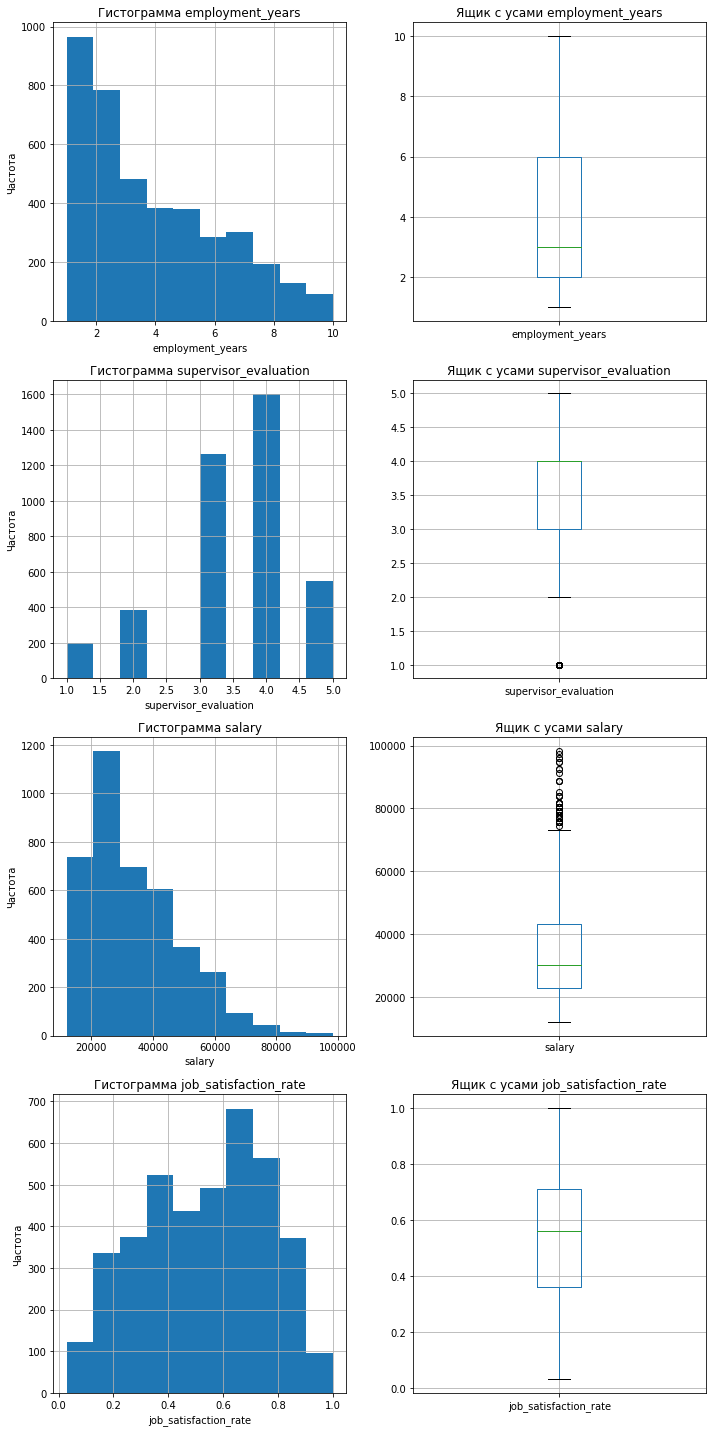

In [35]:
plot_hist_box(df_train)

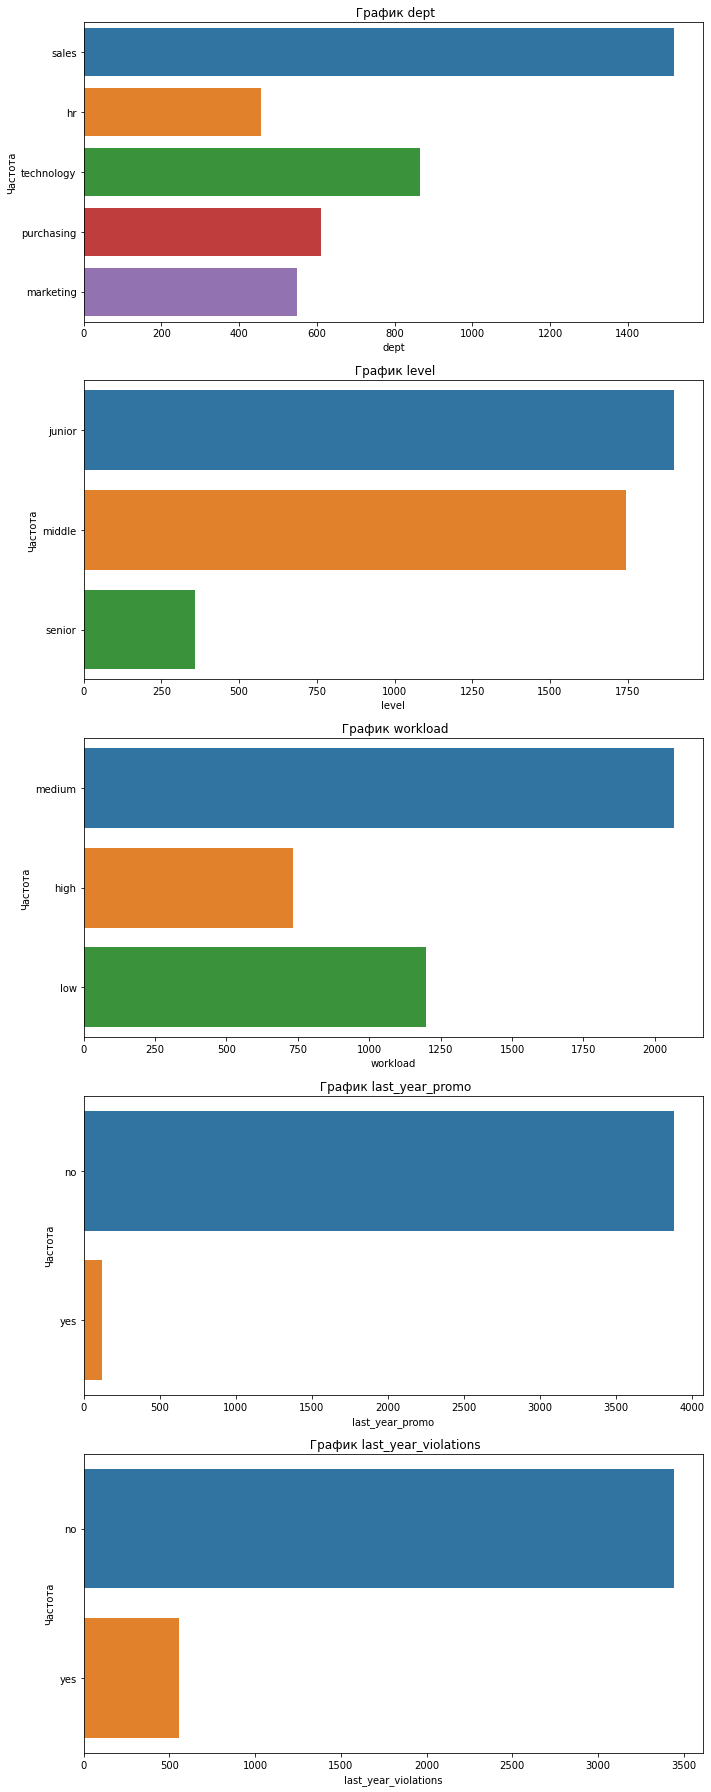

In [36]:
quality_plot(df_train)

В датасете df_train присутствуют выбросы, но нельзя сказать, что они навредят будущей модели. Это не аномалии, а лишь суровая реальность рекрутинга.

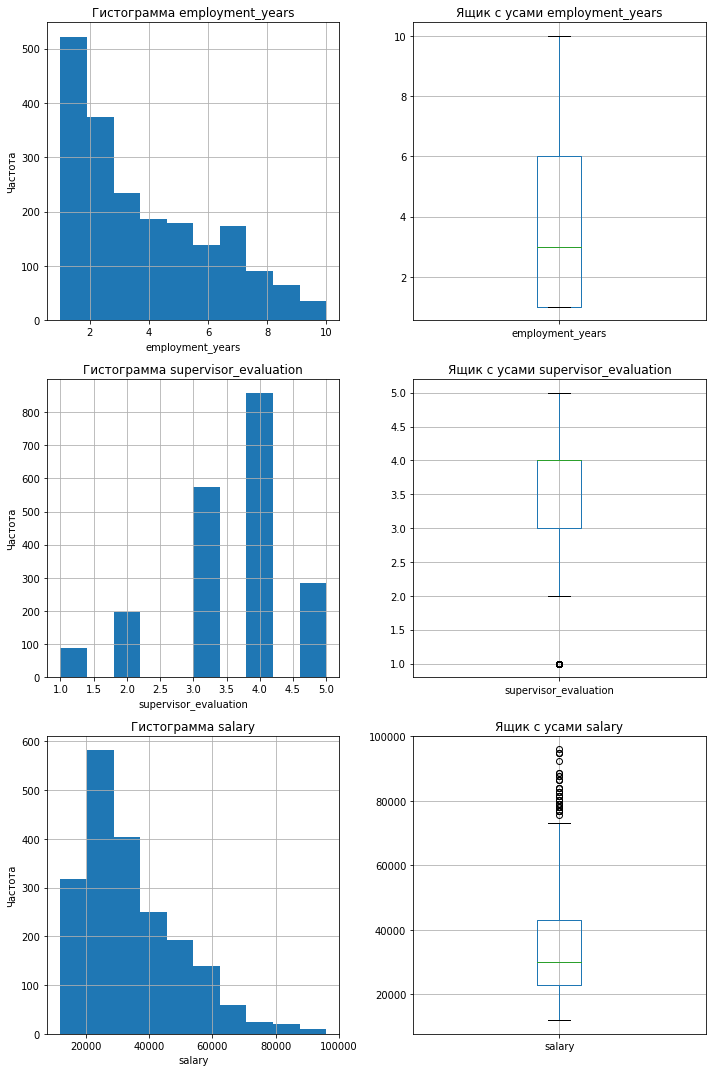

In [37]:
plot_hist_box(df_test)

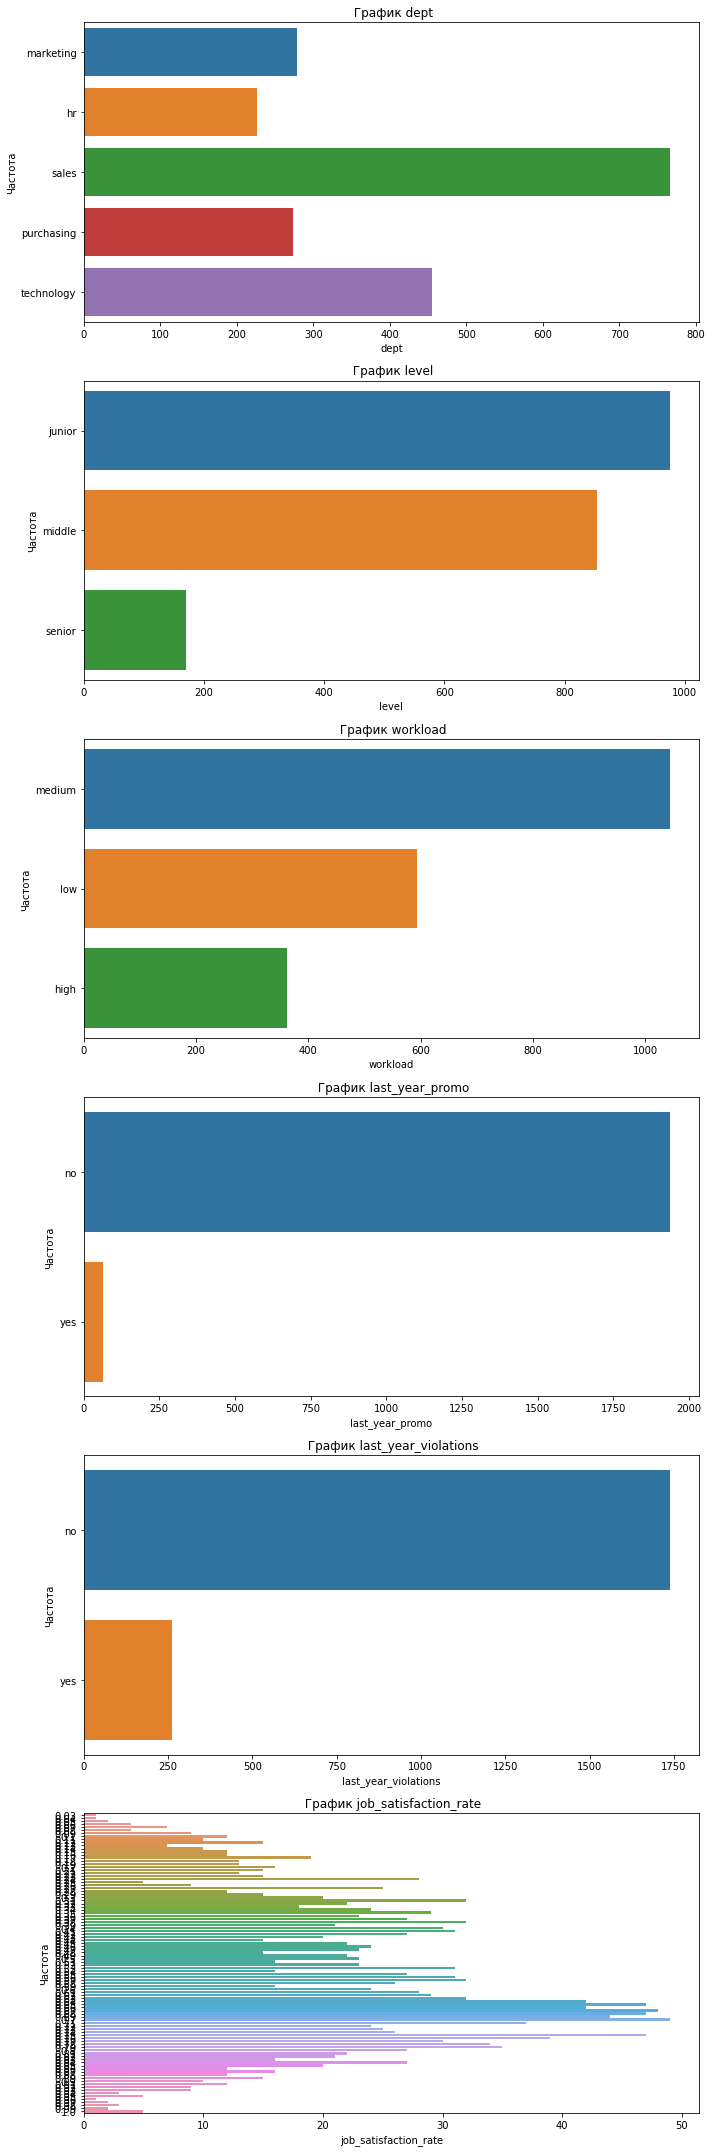

In [38]:
quality_plot(df_test)

По итогам исследовательского анализа не было выявлено критичных проблем с данными. Аномалии отсутствуют. 
Тем не менее, остаются выбросы, а данные распределены неравномерно.

Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.


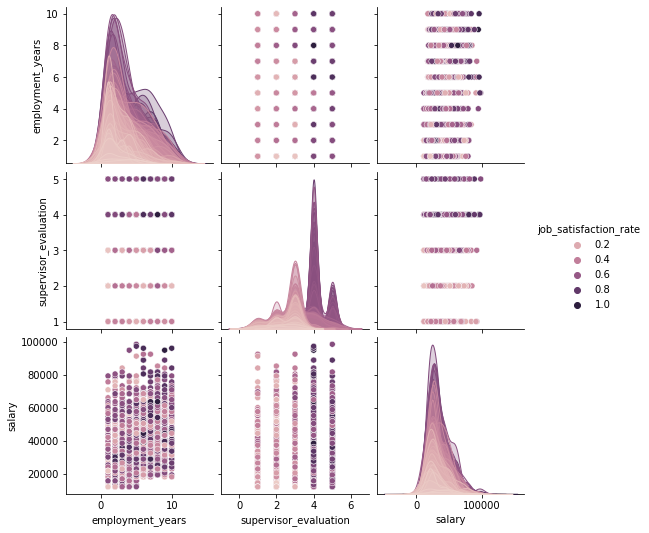

In [39]:
column = df_train.select_dtypes(include = ['int64', 'float64']).columns.to_list()
sns.pairplot(df_train[column], hue = 'job_satisfaction_rate')
plt.show()

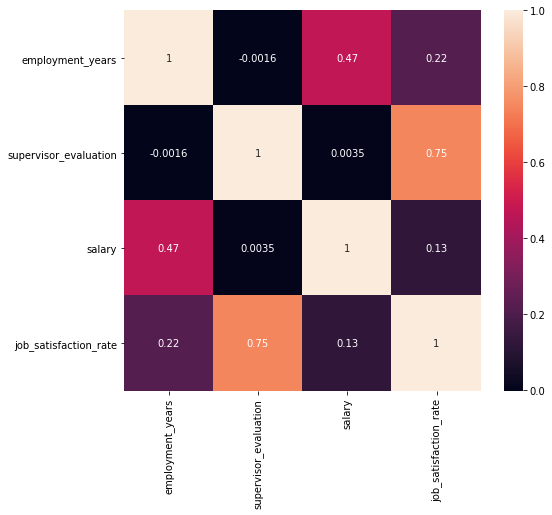

In [40]:
column_quantity = df_train.select_dtypes(include = ['number']).columns
cor = df_train[column_quantity].corr(method = 'spearman')
plt.figure(figsize = (8, 7))
sns.heatmap(cor, annot = True)
plt.show()

In [41]:
df_train.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,sales,junior,medium,2,no,no,1,24000,0.58
1,hr,junior,high,2,no,no,5,38400,0.76
2,sales,junior,low,1,no,no,2,12000,0.11
3,technology,junior,low,4,no,no,2,18000,0.37
4,hr,junior,medium,1,no,no,3,22800,0.20


In [42]:
!pip install phik -q
import phik
quantity = df_train.select_dtypes(include = ['int64', 'float64']).columns.to_list()
df_train.phik_matrix(interval_cols = quantity)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
dept,1.000000,0.000000,0.016542,0.036815,0.000000,0.000000,0.105706,0.282657,0.082659
level,0.000000,1.000000,0.419591,0.682962,0.101668,0.000000,0.000000,0.717761,0.080753
workload,0.016542,0.419591,1.000000,0.181941,0.058663,0.000000,0.037023,0.788820,0.056128
employment_years,0.036815,0.682962,0.181941,1.000000,0.183579,0.056808,0.000000,0.483419,0.325603
last_year_promo,0.000000,0.101668,0.058663,0.183579,1.000000,0.000000,0.013681,0.215025,0.190803
last_year_violations,0.000000,0.000000,0.000000,0.056808,0.000000,1.000000,0.182042,0.010078,0.560348
supervisor_evaluation,0.105706,0.000000,0.037023,0.000000,0.013681,0.182042,1.000000,0.000000,0.764364
salary,0.282657,0.717761,0.788820,0.483419,0.215025,0.010078,0.000000,1.000000,0.165830
job_satisfaction_rate,0.082659,0.080753,0.056128,0.325603,0.190803,0.560348,0.764364,0.165830,1.000000


Обнаружилась мультиколлинеарность целевого признака и входного 'supervisor_evaluation'. Требуется регуляризация

## Подготовка данных

In [43]:
df_train.drop_duplicates()
df_test.drop_duplicates()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,marketing,junior,medium,2,no,no,5,28800,0.79
1,hr,junior,medium,1,no,no,4,30000,0.72
2,sales,middle,low,5,no,no,4,19200,0.64
3,sales,middle,low,6,no,no,4,19200,0.6
4,hr,middle,medium,5,no,no,5,40800,0.75
...,...,...,...,...,...,...,...,...,...
1994,technology,middle,medium,3,no,no,4,52800,0.7
1995,marketing,junior,low,3,no,no,3,20400,0.56
1996,technology,middle,low,3,no,no,2,21600,0.14
1998,technology,middle,low,8,no,no,1,32400,0.43


In [44]:
X_train = df_train[columns_list(df_test_feature)]

In [45]:
y_train = df_train['job_satisfaction_rate']

In [46]:
def smape (test, pred):
    smape_ = 100/len(test) * (abs(test - pred)/((abs(test) + abs(pred))/2)).sum()
    return smape_

smape_scorer = make_scorer(smape, greater_is_better=False)

In [47]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
ohe_columns = ['last_year_promo', 'last_year_violations']
ord_columns = ['dept', 'level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

ohe_pipe = Pipeline(
[
    ('simpleImputer_ohe', SimpleImputer (missing_values = np.nan, strategy = 'most_frequent')
    ),
    ('ohe', OneHotEncoder (drop = 'first')
    ),
])

data_preprocessor = ColumnTransformer (
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], remainder = 'passthrough'
)

In [48]:
data_preprocessor.fit_transform(X_train)

array([[ 0.        ,  0.        ,  2.        , ..., -0.67599051,
        -2.45517399, -0.6662733 ],
       [ 0.        ,  0.        ,  1.        , ..., -0.67599051,
         1.51038061,  0.30024483],
       [ 0.        ,  0.        ,  2.        , ..., -1.06935129,
        -1.46378534, -1.47170507],
       ...,
       [ 0.        ,  0.        ,  2.        , ...,  1.29081341,
         1.51038061, -0.6662733 ],
       [ 0.        ,  0.        ,  2.        , ..., -0.67599051,
        -0.47239669, -0.6662733 ],
       [ 0.        ,  1.        ,  4.        , ...,  0.50409185,
        -2.45517399,  0.70296071]])

Произведена подготовка данных:
1. Тренировочный датасет df_train разбит на X_train с входными признаками и y_train с целевым признаком.
2. В данных присутствуют категориальные, порядковые признаки: level, workload; категориальные признаки: dept, last_year_promo, last_year_violations; количественные признаки: employment_years, supervisor_evaluation, salary. Для каждой группы признаков были запущены соответствующие кодировщики/скейлеры.

## Обучение моделей


In [49]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state = RANDOM_STATE))
])

param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,300), 
        'models__min_samples_leaf': [2, 3 , 4, 5, 6, 7],
        'models__min_samples_split': [2, 4, 6],
        'models__max_leaf_nodes': range(2,300),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

randomized_search = RandomizedSearchCV(
pipe_final,
param_grid,
cv = 5,
scoring= smape_scorer)

randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first'))]),
                                                                               ['last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImputer_before_ord',
                                                                                                SimpleImpu...
                                         'models__max_leaf_nodes': range(2, 300),
                                         'models__min_samples_leaf': [2, 3, 4,
                                                                      5, 6, 7],
                                         'models__min_samples_split': [2, 4, 6],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LinearRegression()],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [50]:
pd.DataFrame(randomized_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__min_samples_split,param_models__min_samples_leaf,param_models__max_leaf_nodes,param_models__max_depth,param_models,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.027564,0.003375,0.009956,0.000859,StandardScaler(),2,4,251,100,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'model...",-15.038592,-14.489672,-14.987552,-15.416635,-14.485085,-14.883507,0.355794,2
1,0.024699,0.000404,0.009375,0.000303,MinMaxScaler(),4,5,149,282,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models_...",-15.671948,-14.854214,-15.118091,-15.880533,-14.760724,-15.257102,0.444701,4
2,0.022910,0.001529,0.008660,0.000815,passthrough,6,3,24,263,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': 'passthrough', 'models__...",-20.116860,-19.645655,-20.108984,-19.597970,-18.402636,-19.574421,0.625892,10
3,0.022356,0.000609,0.008009,0.000494,passthrough,4,2,108,263,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': 'passthrough', 'models__...",-16.855506,-15.571420,-15.963518,-16.179490,-15.076826,-15.929352,0.596056,7
4,0.030240,0.003499,0.011869,0.002387,StandardScaler(),6,7,99,249,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'model...",-16.684549,-15.460857,-16.003949,-16.126744,-14.687666,-15.792753,0.675696,6
5,0.025073,0.002958,0.008089,0.000235,passthrough,4,5,264,127,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': 'passthrough', 'models__...",-14.954681,-14.893971,-14.781507,-15.368825,-14.227670,-14.845331,0.367137,1
6,0.023782,0.003511,0.007983,0.000182,passthrough,6,2,100,229,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': 'passthrough', 'models__...",-16.858352,-15.564321,-16.163629,-16.416173,-15.168890,-16.034273,0.601902,8
7,0.021996,0.000718,0.007623,0.000042,passthrough,2,2,179,39,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': 'passthrough', 'models__...",-15.594890,-14.801005,-15.074338,-15.707388,-14.593002,-15.154124,0.435039,3
8,0.024821,0.000805,0.009127,0.000249,StandardScaler(),6,5,89,136,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'model...",-16.962210,-16.011751,-16.273225,-16.515713,-15.376319,-16.227843,0.528396,9
9,0.024041,0.000255,0.009062,0.000336,MinMaxScaler(),4,6,128,282,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models_...",-16.072231,-14.822330,-15.377663,-16.145967,-14.430108,-15.369660,0.675078,5


In [51]:
best_params = randomized_search.best_params_
best_score = randomized_search.best_score_
print(f" Лучшие параметры модели: {best_params}")
print(f" SMAPE:: {best_score}")

 Лучшие параметры модели: {'preprocessor__num': 'passthrough', 'models__min_samples_split': 4, 'models__min_samples_leaf': 5, 'models__max_leaf_nodes': 264, 'models__max_depth': 127, 'models': DecisionTreeRegressor(random_state=42)}
 SMAPE:: -14.845330703628747


Исходя из полученных метрик cреднего абсолютного отклонения, модель DesicionTreeRegressor является наиболее оптимальной моделью для дальнейшей работы. Тем не менее, следует проверить качество обеих моделей на работе с тестовой выборкой для полного понимания картины.

In [52]:
X_test = df_test.drop(['job_satisfaction_rate'], axis=1)
y_test = df_test['job_satisfaction_rate']


y_pred = randomized_search.predict(X_test)



In [53]:
print(f" SMAPE by {randomized_search.best_params_} {smape(y_test.to_numpy(), y_pred)}")


 SMAPE by {'preprocessor__num': 'passthrough', 'models__min_samples_split': 4, 'models__min_samples_leaf': 5, 'models__max_leaf_nodes': 264, 'models__max_depth': 127, 'models': DecisionTreeRegressor(random_state=42)} 13.84478684068985


## Вывод 

Был построен пайплайн, в котором была произведена:

Подготовка данных

1. Тренировочный датасет df_train разбит на X_train с входными признаками и y_train с целевым признаком.
2. В данных присутствуют категориальные, порядковые признаки: level, workload; категориальные признаки: dept, last_year_promo, last_year_violations; количественные признаки: employment_years, supervisor_evaluation, salary. Для каждой группы признаков были запущены соответствующие кодировщики/скейлеры.

Запщуен поиск лучшей модели под метрику SMAPE. 

Так как задача, которая стоит перед нами - регрессия, пришлось использовать новую модель - TreeDecisionRegressor. По итогам подбора, при помощи метода RandomizedSearchCV, новоиспеченная модель и оказалась лучшей, при работе с тренировочной выборкой. Метрика на тренировочных данных - 14.42. Метрика на тестовых - 13.22.

# Задача 2: предсказание увольнения сотрудника из компании

## Выгрузка данных

In [54]:
df_train_quit = pd.read_csv('/datasets/train_quit.csv')
df_test_quit_f = pd.read_csv('/datasets/test_features.csv')
df_test_quit_t = pd.read_csv('/datasets/test_target_quit.csv')

In [55]:
info(df_train_quit)

       id        dept   level workload  employment_years last_year_promo  \
0  723290       sales  middle     high                 2              no   
1  814010       sales  junior   medium                 2              no   
2  155091  purchasing  middle   medium                 5              no   
3  257132       sales  junior   medium                 2              no   
4  910140   marketing  junior   medium                 2              no   

  last_year_violations  supervisor_evaluation  salary quit  
0                   no                      4   54000   no  
1                   no                      4   27600   no  
2                   no                      1   37200   no  
3                  yes                      3   24000  yes  
4                   no                      5   25200   no  
                  id  employment_years  supervisor_evaluation        salary
count    4000.000000       4000.000000            4000.000000   4000.000000
mean   552099.283750     

In [56]:
info(df_test_quit_f)

       id       dept   level workload  employment_years last_year_promo  \
0  485046  marketing  junior   medium                 2              no   
1  686555         hr  junior   medium                 1              no   
2  467458      sales  middle      low                 5              no   
3  418655      sales  middle      low                 6              no   
4  789145         hr  middle   medium                 5              no   

  last_year_violations  supervisor_evaluation  salary  
0                   no                      5   28800  
1                   no                      4   30000  
2                   no                      4   19200  
3                   no                      4   19200  
4                   no                      5   40800  
                  id  employment_years  supervisor_evaluation        salary
count    2000.000000       2000.000000            2000.000000   2000.000000
mean   552765.213500          3.666500               3.526500

In [57]:
info(df_test_quit_t)

       id quit
0  999029  yes
1  372846   no
2  726767   no
3  490105   no
4  416898  yes
                  id
count    2000.000000
mean   552765.213500
std    253851.326129
min    100298.000000
25%    339052.000000
50%    550793.000000
75%    765763.750000
max    999029.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Выгрузили данные в датасеты и проверили первичный осмотр.


## Предобработка данных

In [58]:
df_test_quit_f = df_test_quit_f.set_index('id')
df_test_quit_t = df_test_quit_t.set_index('id')
df_train_quit = df_train_quit.set_index('id')

In [59]:
quantity_analysis(df_train_quit)

,quantity_missing,percent_missing,duplicates
dept,0,0.0,1413
level,0,0.0,1413
workload,0,0.0,1413
employment_years,0,0.0,1413
last_year_promo,0,0.0,1413
last_year_violations,0,0.0,1413
supervisor_evaluation,0,0.0,1413
salary,0,0.0,1413
quit,0,0.0,1413


In [60]:
quality_analysis(df_train_quit)

dept: 5
['sales' 'purchasing' 'marketing' 'technology' 'hr']
level: 3
['middle' 'junior' 'sinior']
workload: 3
['high' 'medium' 'low']
last_year_promo: 2
['no' 'yes']
last_year_violations: 2
['no' 'yes']
quit: 2
['no' 'yes']


In [61]:
quantity_analysis(df_test_quit_f)

,quantity_missing,percent_missing,duplicates
dept,2,0.10,557
level,1,0.05,557
workload,0,0.00,557
employment_years,0,0.00,557
last_year_promo,0,0.00,557
last_year_violations,0,0.00,557
supervisor_evaluation,0,0.00,557
salary,0,0.00,557


In [62]:
quality_analysis(df_test_quit_f)

dept: 6
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level: 3
['junior' 'middle' 'sinior' nan]
workload: 4
['medium' 'low' 'high' ' ']
last_year_promo: 2
['no' 'yes']
last_year_violations: 2
['no' 'yes']


In [63]:
quality_analysis(df_test_quit_t)

quit: 2
['yes' 'no']


С данные аналогичные неполадки, как и в прошлых датасетах. Будем исправлять уже проверенным способом.

In [64]:
df_train_quit['level'] = df_train_quit['level'].str.replace('sinior', 'senior')
df_test_quit_f['level'] = df_test_quit_f['level'].str.replace('sinior', 'senior')


In [65]:
df_test_quit = df_test_quit_f.join(df_test_quit_t)

In [66]:
df_train_quit_preproc = data_preprocessor_nan.fit_transform(df_train_quit)
columns_train_quit = columns_list(df_train_quit)
df_train_quit = pd.DataFrame(df_train_quit_preproc, columns=columns_train_quit)

In [67]:
df_test_quit_preproc = data_preprocessor_nan.transform(df_test_quit)
columns_test_quit = columns_list(df_test_quit)
df_test_quit = pd.DataFrame(df_test_quit_preproc, columns=columns_test_quit)

In [68]:
rename_features (df_train_quit)
rename_features (df_test_quit)


In [69]:
quality_analysis(df_test_quit)

dept: 5
['marketing' 'hr' 'sales' 'purchasing' 'technology']
level: 3
['junior' 'middle' 'senior']
workload: 3
['medium' 'low' 'high']
employment_years: 10
[2 1 5 6 3 9 7 4 8 10]
last_year_promo: 2
['no' 'yes']
last_year_violations: 2
['no' 'yes']
supervisor_evaluation: 5
[5 4 3 1 2]
salary: 66
[28800 30000 19200 40800 42000 26400 49200 62400 14400 36000 33600 44400
 27600 12000 64800 20400 34800 15600 18000 50400 31200 51600 16800 43200
 52800 32400 37200 58800 24000 21600 48000 45600 25200 63600 61200 56400
 38400 46800 55200 13200 39600 54000 57600 68400 22800 72000 81600 60000
 66000 67200 70800 76800 79200 69600 94800 82800 80400 87600 86400 96000
 78000 75600 73200 84000 88800 92400]
quit: 2
['no' 'yes']


In [70]:
train_columns_quantity_int = [ 'employment_years', 'supervisor_evaluation', 'salary']
for i in train_columns_quantity_int:
    df_train_quit[i] = df_train_quit[i].astype(int)
df_train_quit.info()

test_columns_quantity_int = [ 'employment_years', 'supervisor_evaluation', 'salary']
for i in test_columns_quantity_int:
    df_test_quit[i] = df_test_quit[i].astype(int)
df_test_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   4000 non-null   object
 1   level                  4000 non-null   object
 2   workload               4000 non-null   object
 3   employment_years       4000 non-null   int64 
 4   last_year_promo        4000 non-null   object
 5   last_year_violations   4000 non-null   object
 6   supervisor_evaluation  4000 non-null   int64 
 7   salary                 4000 non-null   int64 
 8   quit                   4000 non-null   object
dtypes: int64(3), object(6)
memory usage: 281.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   2000 non-null   object
 1   level            

## Исследовательский анализ данных

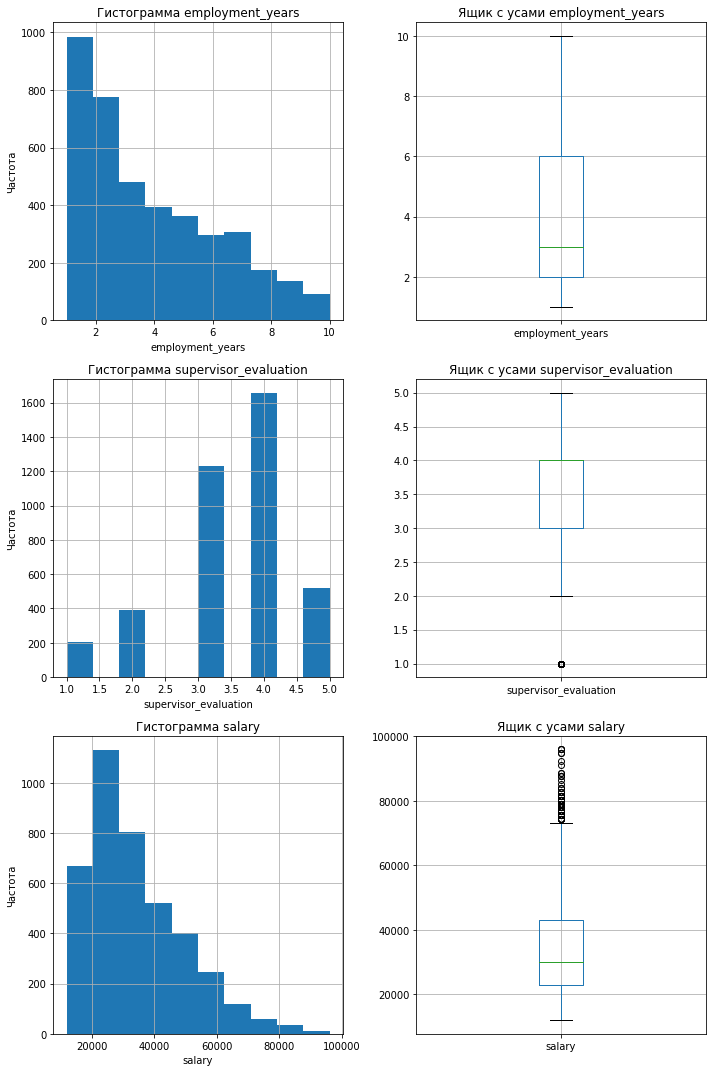

In [71]:
plot_hist_box(df_train_quit)

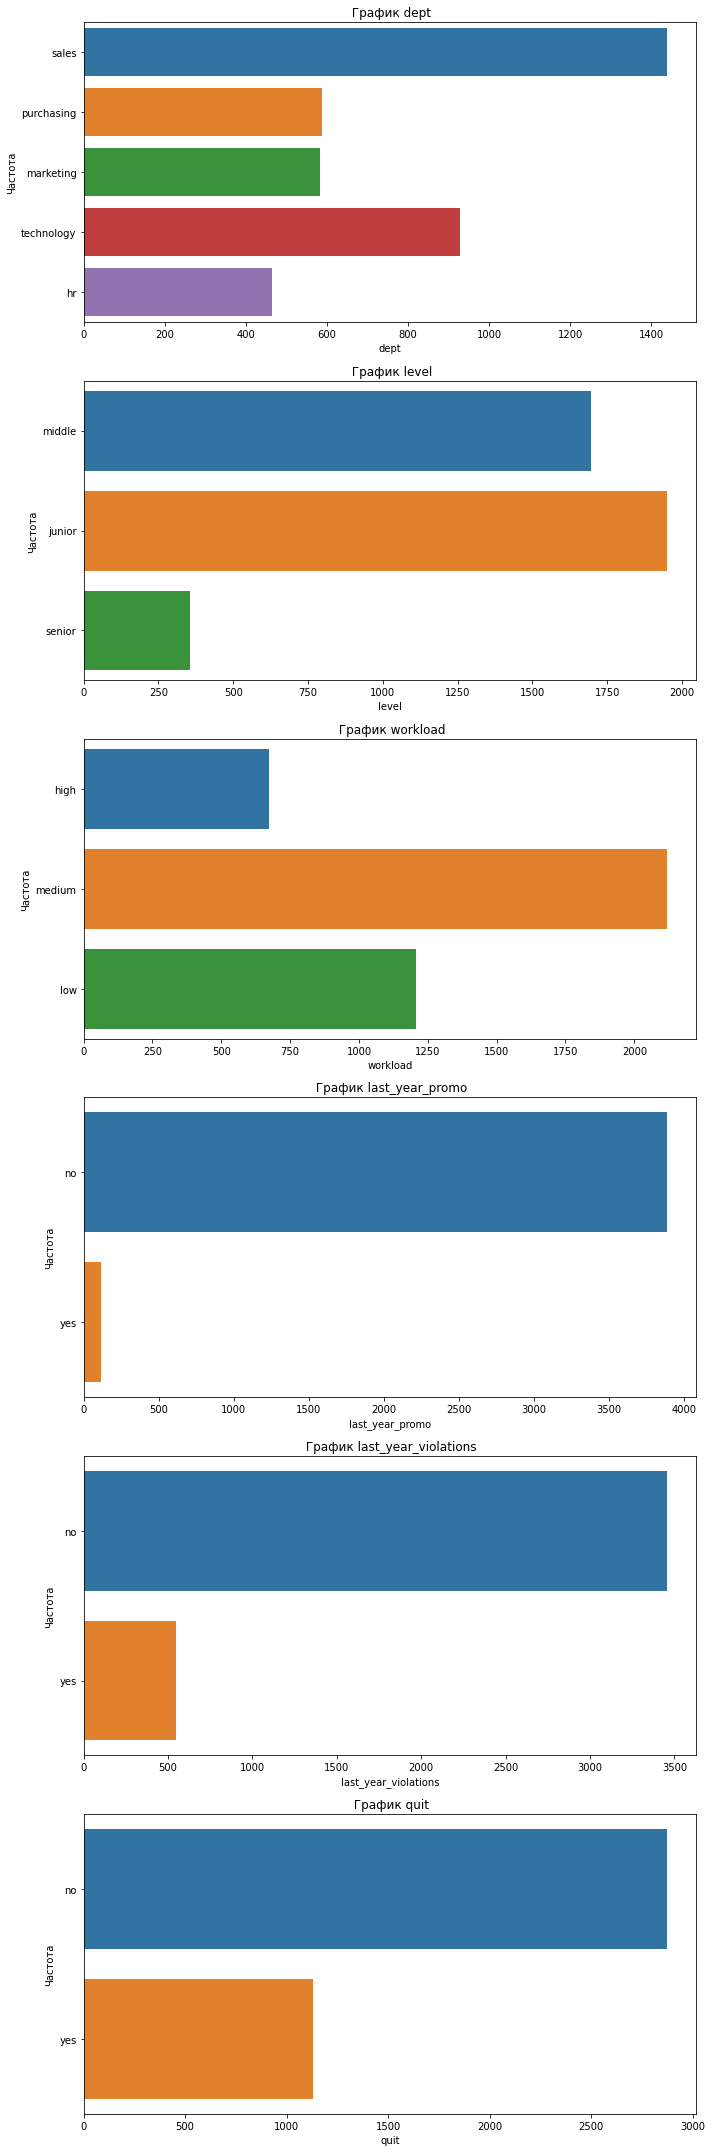

In [72]:
quality_plot(df_train_quit)

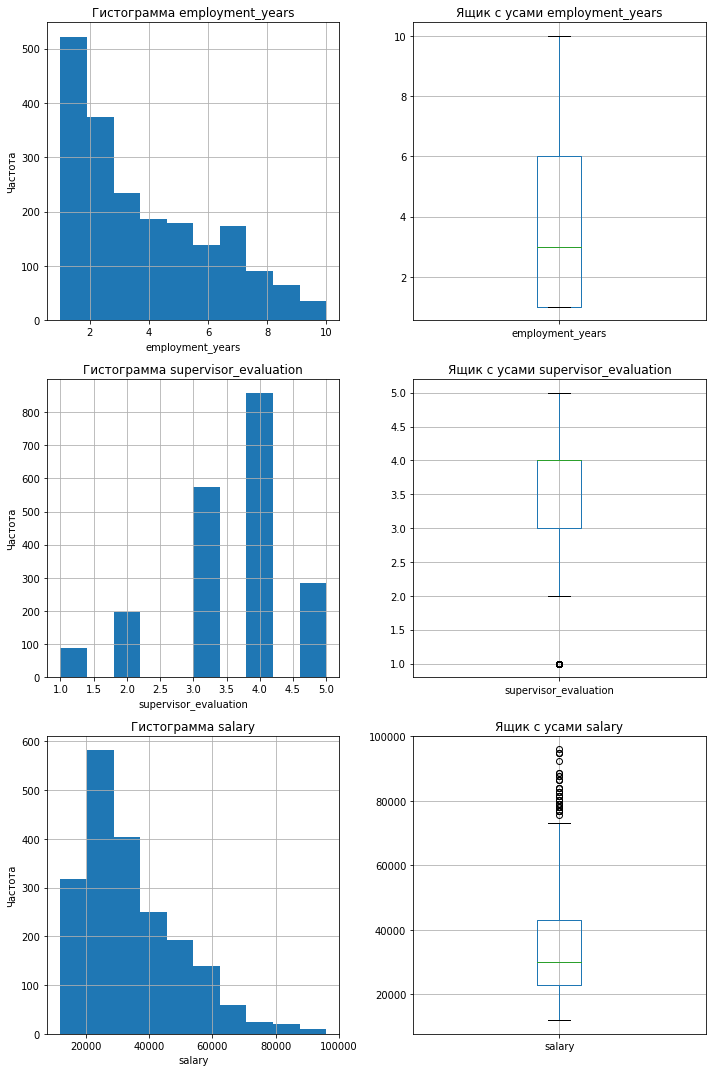

In [73]:
plot_hist_box(df_test_quit)

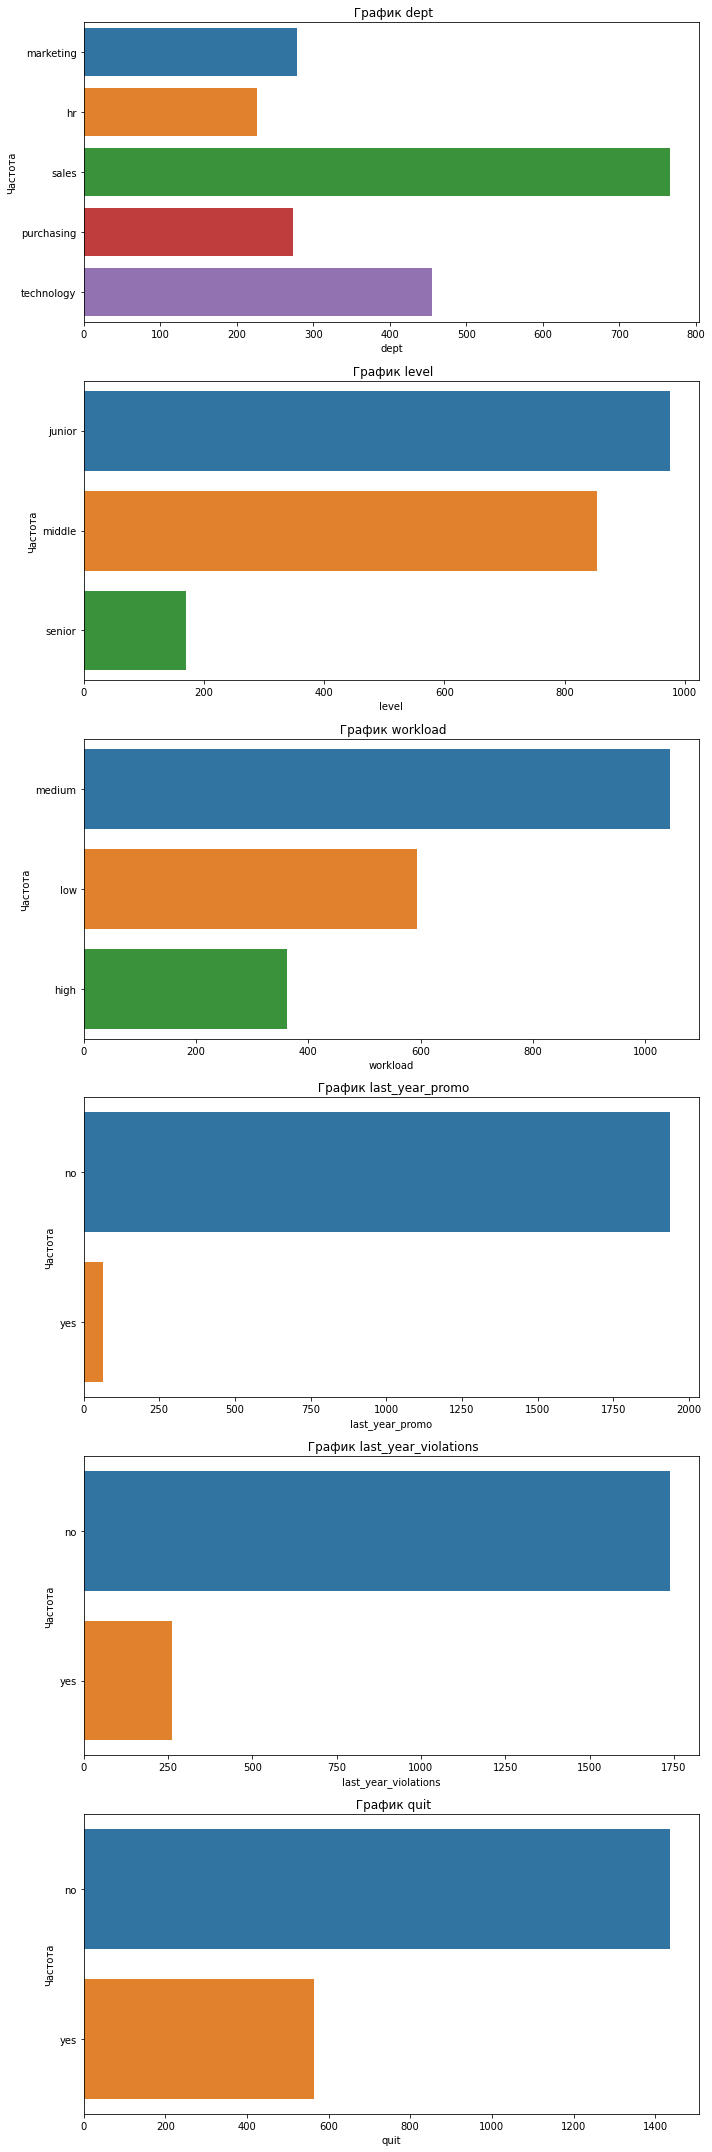

In [74]:
quality_plot(df_test_quit)

По итогам исследовательского анализа не было выявлено критичных проблем с данными. Аномалии отсутствуют. 
Тем не менее, остаются выбросы, а данные распределены неравномерно. 

In [75]:
df_train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   4000 non-null   object
 1   level                  4000 non-null   object
 2   workload               4000 non-null   object
 3   employment_years       4000 non-null   int64 
 4   last_year_promo        4000 non-null   object
 5   last_year_violations   4000 non-null   object
 6   supervisor_evaluation  4000 non-null   int64 
 7   salary                 4000 non-null   int64 
 8   quit                   4000 non-null   object
dtypes: int64(3), object(6)
memory usage: 281.4+ KB


In [76]:
df_train_quit[df_train_quit['dept'] == 'technology']['workload'].value_counts()

medium    493
low       286
high      149
Name: workload, dtype: int64

Надо уточнить, что заказчик называет высокой, средней и низкой нагрузкой, но технари, чаще всего, не сильно нагружены. Может быть проблема в другом.

In [77]:
dept = df_train_quit['dept'].value_counts()
quit_dept = df_train_quit.query('quit == "yes"')['dept'].value_counts()
df_quit = pd.DataFrame({'all_emp': df_train['dept'].value_counts(),
                           'quit_emp':df_train_quit.query('quit == "yes"')['dept'].value_counts(),
                           'percent': (df_train_quit.query('quit == "yes"')['dept'].value_counts())/df_train['dept'].value_counts()
                            })
df_quit.sort_values(by = 'percent', ascending = False)
dept_name = ['sales', 'technology', 'purchasing', 'marketing', 'hr']
salary_quit = []
salary_stay = []
for i in dept_name:
    dept = df_train_quit[df_train_quit['dept'] == i]
    salary_quit.append(dept[dept['quit'] == 'yes']['salary'].mean())  
    salary_stay.append(dept[dept['quit'] == 'no']['salary'].mean())
df_salary = pd.DataFrame({'salary_quit': salary_quit,
                        'salary_stay': salary_stay}, index = dept_name)
df_salary['delta'] = df_salary['salary_stay'] - df_salary['salary_quit']
df_portrait = pd.concat([df_quit, df_salary], axis=1)
df_portrait.sort_values(by = 'percent', ascending = False)

,all_emp,quit_emp,percent,salary_quit,salary_stay,delta
technology,866,276,0.318707,27686.956522,42003.680982,14316.724460
marketing,550,163,0.296364,24058.895706,39161.813842,15102.918137
purchasing,610,166,0.272131,23378.313253,35840.758294,12462.445041
sales,1518,407,0.268116,21832.923833,35278.370514,13445.446681
hr,456,116,0.254386,22520.689655,37324.137931,14803.448276


Первые на увольнение стоят технари. Почти 32% штата готово увольняться. На втором месте маркетологи. Самые общительные категории сотрудников - продажники и рекрутеры меньше всех остальных хотят оставить все и написать по собственному.

Точно можно сказать только одно - технари хотят очень много. Их средняя зарплата при увольнении больше "конкурентов", разница с зарплатой постоянного сотрудника не так велика. Нагрузка у них, в большей степени, средняя. Возможно, проблема более глубокая. Для этого мы и будем строить модель.

In [78]:
df_check = df_test_quit_t.join(df_test_target)

(array([0.17947908, 0.35895816, 0.56715389, 0.86149958, 0.83278293,
        1.50762427, 2.21836143, 2.26861557, 1.16302444, 0.351779  ]),
 array([0.03 , 0.127, 0.224, 0.321, 0.418, 0.515, 0.612, 0.709, 0.806,
        0.903, 1.   ]),
 <BarContainer object of 10 artists>)

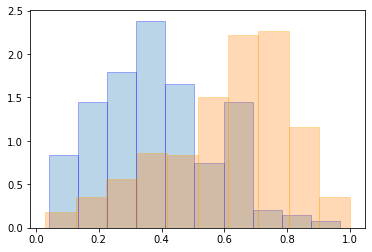

In [79]:
plt.hist(data = df_check.query('quit == "yes"'), x = 'job_satisfaction_rate',
        edgecolor='blue', alpha = 0.3, density=True)
plt.hist(data = df_check.query('quit == "no"'), x = 'job_satisfaction_rate',
        edgecolor='orange', alpha = 0.3, density=True)

Аналитики, возможно, правы. По крайней мере, визуально заметно, что голубой график (те, кто уволились) имеет распределение на интервале 0.0 - 0.6, в то время как график удовлетворенности текущих работников имеет пиковую частоту на показателях 0.5 - 0.9. Я бы сказал, что они не на 100% правы, но своим заявлением подготовили почву для дальнейших исследований.

## Добавление нового входного признака

In [80]:
def rate_add (df):
    column = columns_list(df_test_feature)
    predict_rate_train = randomized_search.predict(df[column])
    df_predict_rate_train = pd.DataFrame({'job_satis_rate': predict_rate_train})
    df_train_quit = df.join(df_predict_rate_train)
    return df_train_quit

<font color='blue'><b>Комментарий ревьюера : </b></font> ✔️\
<font color='green'> Отлично, что добавляется предсказание предыдущей модели.</font>

In [81]:
df_train_quit = rate_add (df_train_quit)

In [82]:
df_test_quit = rate_add (df_test_quit)

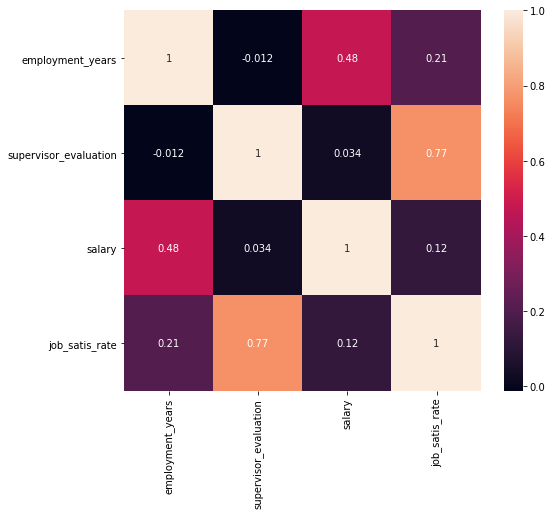

In [83]:
all_columns = df_train_quit.columns.to_list()
cor = df_train_quit[all_columns].corr(method = 'spearman')
plt.figure(figsize = (8, 7))
sns.heatmap(cor, annot = True)
plt.show()

In [84]:
quantity = df_train_quit.select_dtypes(include = ['int64', 'float64']).columns.to_list()
df_train_quit.phik_matrix(interval_cols = quantity)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satis_rate
dept,1.000000,0.000000,0.000000,0.000000,0.000000,0.044274,0.042772,0.280300,0.000000,0.178057
level,0.000000,1.000000,0.479480,0.692676,0.110585,0.000000,0.007189,0.745104,0.312799,0.304938
workload,0.000000,0.479480,1.000000,0.213013,0.044388,0.014063,0.000000,0.793876,0.132243,0.282918
employment_years,0.000000,0.692676,0.213013,1.000000,0.156494,0.000000,0.000000,0.491915,0.659093,0.461412
last_year_promo,0.000000,0.110585,0.044388,0.156494,1.000000,0.000000,0.032376,0.215043,0.157370,0.684879
last_year_violations,0.044274,0.000000,0.014063,0.000000,0.000000,1.000000,0.179228,0.086087,0.185071,0.641205
supervisor_evaluation,0.042772,0.007189,0.000000,0.000000,0.032376,0.179228,1.000000,0.055330,0.245489,0.785261
salary,0.280300,0.745104,0.793876,0.491915,0.215043,0.086087,0.055330,1.000000,0.564154,0.316399
quit,0.000000,0.312799,0.132243,0.659093,0.157370,0.185071,0.245489,0.564154,1.000000,0.542982
job_satis_rate,0.178057,0.304938,0.282918,0.461412,0.684879,0.641205,0.785261,0.316399,0.542982,1.000000


## Подготовка данных

In [85]:
df_train_quit.drop_duplicates()
df_test_quit.drop_duplicates()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satis_rate
0,marketing,junior,medium,2,no,no,5,28800,no,0.829905
1,hr,junior,medium,1,no,no,4,30000,no,0.669508
2,sales,middle,low,5,no,no,4,19200,no,0.669500
3,sales,middle,low,6,no,no,4,19200,no,0.669500
4,hr,middle,medium,5,no,no,5,40800,no,0.824127
...,...,...,...,...,...,...,...,...,...,...
1990,hr,senior,high,2,no,no,3,81600,no,0.304444
1991,technology,junior,high,2,no,no,4,48000,no,0.799667
1994,technology,middle,medium,3,no,no,4,52800,no,0.651549
1996,technology,middle,low,3,no,no,2,21600,yes,0.170000


In [86]:
columns_to_train = [
 'dept',
 'level',
 'workload',
 'employment_years',
 'last_year_promo',
 'last_year_violations',
 'supervisor_evaluation',
 'salary',
 'job_satis_rate']
ohe_columns = ['last_year_promo', 'last_year_violations']
ord_columns = ['dept', 'level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satis_rate']
data_preprocessor.fit_transform(df_train_quit[columns_to_train])

array([[ 0.        ,  0.        ,  2.        , ...,  0.52319722,
         1.33290466,  0.65761905],
       [ 0.        ,  0.        ,  2.        , ...,  0.52319722,
        -0.40960968,  0.82990476],
       [ 0.        ,  0.        ,  3.        , ..., -2.46507821,
         0.2240319 ,  0.36913043],
       ...,
       [ 0.        ,  1.        ,  3.        , ...,  0.52319722,
        -1.43927724,  0.54875   ],
       [ 0.        ,  0.        ,  3.        , ...,  0.52319722,
        -0.01358369,  0.49529412],
       [ 0.        ,  0.        ,  2.        , ..., -0.47289459,
        -0.40960968,  0.51366667]])

## Обучение модели

In [87]:
X_train = df_train_quit[columns_to_train]
y_train = df_train_quit['quit']

In [88]:
pipe_final_2 = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state = RANDOM_STATE))
])

param_grid = [
    {'models': [DecisionTreeClassifier(random_state = RANDOM_STATE)],
    'models__max_features': range (2, 15),
    'models__max_depth': range (2, 15),
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {'models': [KNeighborsClassifier()],
    'models__n_neighbors': range (1, 15),
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {'models': [LogisticRegression(random_state = RANDOM_STATE)],
    'models__C': range (0, 10),
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {'models': [SVC(random_state = RANDOM_STATE, probability = True)],
    'models__kernel': ['linear', 'rbf'],
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

randomized_search = RandomizedSearchCV(
pipe_final_2,
param_grid,
cv = 5,
scoring = 'roc_auc',
random_state = RANDOM_STATE,
n_jobs = -1)

randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first'))]),
                                                                               ['last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImputer_before_ord',
                                                                                                SimpleImpu...
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(random_state=42)],
                                         'models__C': range(0, 10),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(probability=True,
                                                        random_state=42)],
                                         'models__kernel': ['linear', 'rbf'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [89]:
best_params = randomized_search.best_params_
best_score = randomized_search.best_score_
print(f" Лучшие параметры модели: {best_params}")
print(f" Roc-Auc:: {best_score}")

 Лучшие параметры модели: {'preprocessor__num': StandardScaler(), 'models__max_features': 7, 'models__max_depth': 5, 'models': DecisionTreeClassifier(random_state=42)}
 Roc-Auc:: 0.9293409474056924


In [90]:
pd.DataFrame(randomized_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__max_features,param_models__max_depth,param_models,param_models__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.031572,0.010969,0.010882,0.000324,passthrough,12,11,DecisionTreeClassifier(random_state=42),NaN,"{'preprocessor__num': 'passthrough', 'models__...",0.887200,0.908935,0.892345,0.882181,0.914623,0.897057,0.012572,7
1,0.026612,0.000190,0.010553,0.000367,passthrough,12,12,DecisionTreeClassifier(random_state=42),NaN,"{'preprocessor__num': 'passthrough', 'models__...",0.885809,0.909233,0.876573,0.880874,0.906740,0.891846,0.013522,9
2,0.026053,0.000440,0.011458,0.000245,StandardScaler(),6,4,DecisionTreeClassifier(random_state=42),NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.924773,0.911776,0.918311,0.916388,0.938400,0.921930,0.009233,3
3,0.027563,0.001214,0.012328,0.001171,MinMaxScaler(),3,14,DecisionTreeClassifier(random_state=42),NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.887556,0.893244,0.872633,0.857517,0.906413,0.883473,0.016909,10
4,0.028191,0.000761,0.020354,0.000166,MinMaxScaler(),NaN,NaN,KNeighborsClassifier(),6,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.924309,0.919501,0.913146,0.920261,0.925449,0.920534,0.004339,4
5,0.028952,0.000500,0.012223,0.000224,MinMaxScaler(),12,9,DecisionTreeClassifier(random_state=42),NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.903803,0.911610,0.888429,0.907750,0.921052,0.906529,0.010708,6
6,0.024358,0.000462,0.010965,0.000281,passthrough,12,4,DecisionTreeClassifier(random_state=42),NaN,"{'preprocessor__num': 'passthrough', 'models__...",0.926435,0.916039,0.920454,0.923703,0.938832,0.925093,0.007694,2
7,0.030016,0.002579,0.013183,0.002105,StandardScaler(),11,8,DecisionTreeClassifier(random_state=42),NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.912618,0.911706,0.897455,0.917637,0.922894,0.912462,0.008502,5
8,0.030460,0.001915,0.012789,0.001263,StandardScaler(),7,5,DecisionTreeClassifier(random_state=42),NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.929851,0.925809,0.930861,0.928810,0.931374,0.929341,0.001973,1
9,0.028809,0.001096,0.012302,0.000412,StandardScaler(),5,11,DecisionTreeClassifier(random_state=42),NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.884089,0.898017,0.885434,0.894441,0.911312,0.894659,0.009854,8


In [91]:
X_test = df_test_quit[columns_to_train]
y_test = df_test_quit['quit']
y_pred_proba = randomized_search.predict_proba(X_test)
roc_auc_score(y_test, y_pred_proba[:,1])

0.9249960489144392

  0%|          | 0/15 [00:00<?, ?it/s]

auto_size_plot=False is deprecated and is now ignored! Use plot_size=None instead.


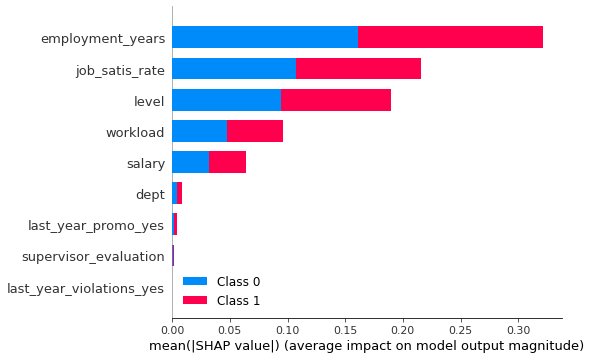

In [92]:
#Вытягиваем модель из пайплайна 
best_model = randomized_search.best_estimator_.named_steps['models']
#Сохраняем в переменную пайп с предобработкой данных
preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']
# Записываем в переменные предобработнные тренировочную и тестовую выборки
X_train_preprocessed = preprocessor.transform(X_train[columns_to_train])
X_test_preprocessed = preprocessor.transform(X_test[columns_to_train])
# Вытягиваем названия признаков для дальнейшего построения датафрейма

column_transformer = pipe_final_2.named_steps['preprocessor']
ohe_pipeline = column_transformer.named_transformers_['ohe']
ohe_encoder = ohe_pipeline.named_steps['ohe']

ohe_feature_names = ohe_encoder.get_feature_names_out(input_features=ohe_columns)
ord_feature_names = ord_columns
num_feature_names = num_columns

all_feature_names = np.concatenate([ohe_feature_names,ord_feature_names, num_feature_names]) 
# Строим датафреймы 
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed,
                                       columns=all_feature_names)
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed,
                                      columns=all_feature_names)
# Семплируем данные 
X_train_preprocessed_smpl = shap.sample(X_train_preprocessed_df,
                                        15, random_state=RANDOM_STATE)
X_test_preprocessed_smpl = shap.sample(X_test_preprocessed_df,
                                       15, random_state=RANDOM_STATE)
# Применяем метод SHAP для оценки важности признаков
explainer = shap.KernelExplainer(best_model.predict_proba, X_train_preprocessed_smpl)
shap_values = explainer.shap_values(X_test_preprocessed_smpl)
shap.summary_plot(shap_values, X_test_preprocessed_smpl,
                      max_display=25, auto_size_plot=True)

Анализируя важность признаков при работе модели, можем заметить, что наибольший вклад вносят признаки level, employment_years, job_satis_rate. Аналитики были правы.

In [93]:
df_level = pd.DataFrame(df_train_quit.query('quit == "yes"')['level'].value_counts())


In [94]:
level = df_train_quit['level'].value_counts()
quit_level = df_train_quit.query('quit == "yes"')['level'].value_counts()
df_quit_level = pd.DataFrame({'all_emp': level,
                           'quit_emp':quit_level,
                           'percent': quit_level/level
                            })
df_quit_level.sort_values(by = 'percent', ascending = False)
level_name = ['junior', 'middle', 'senior']
salary_quit_level = []
salary_stay_level = []
for j in level_name:
    level = df_train_quit[df_train_quit['level'] == j]
    salary_quit_level.append(level[level['quit'] == 'yes']['salary'].mean())  
    salary_stay_level.append(level[level['quit'] == 'no']['salary'].mean())

df_salary_level = pd.DataFrame({'salary_quit': salary_quit_level,
                         'salary_stay': salary_stay_level}, index = level_name)
df_salary_level['delta'] = df_salary_level['salary_stay'] - df_salary_level['salary_quit']
df_portrait = pd.concat([df_quit_level, df_salary_level], axis=1)
df_portrait.sort_values(by = 'percent', ascending = False)

,all_emp,quit_emp,percent,salary_quit,salary_stay,delta
junior,1949,1003,0.514623,22508.075773,25661.733615,3153.657843
middle,1694,108,0.063754,33122.222222,40075.914250,6953.692027
senior,357,17,0.047619,46447.058824,60130.588235,13683.529412


In [95]:

def plt_analysis (df, x, bins):
    num_plots = df['level'].nunique()
    plt.figure(figsize=(10, 2 * num_plots))
    
    plt.hist(data = df[df['level'] == 'junior'].query('quit == "yes"'),
             x = x,
            edgecolor='blue', alpha = 0.3, bins = bins)
    plt.hist(data = df[df['level'] == 'junior'].query('quit == "no"'),
             x = x,
            edgecolor='orange', alpha = 0.3,  bins = bins)
    plt.title(f'Частота распределения {x}')
    plt.legend ('YN')
    plt.show()

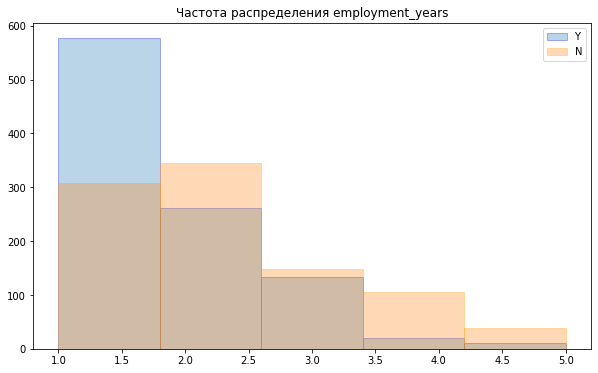

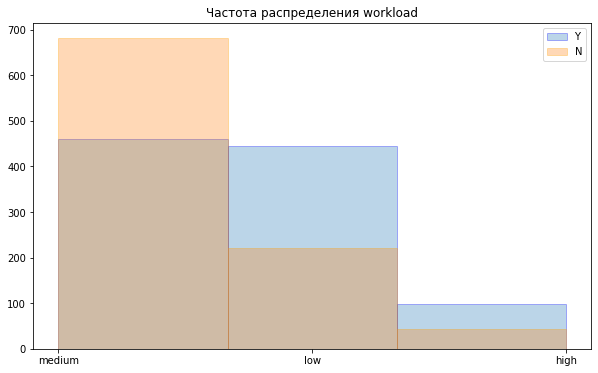

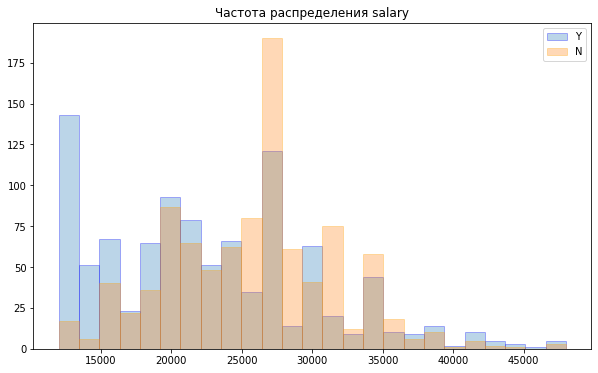

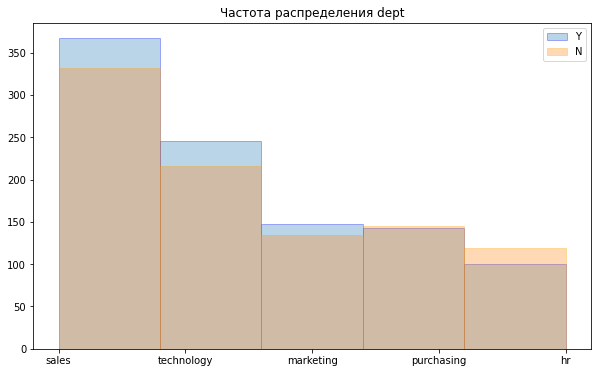

In [96]:
plt_analysis(df_train_quit, 'employment_years', 5)
plt_analysis(df_train_quit, 'workload', 3)
plt_analysis(df_train_quit, 'salary', 25)
plt_analysis(df_train_quit, 'dept', 5)

Продажники и технари явно не довольны чем-то. Типичный сотрудник, который готов писать по собственному - junior, работающий в департаменте sales или technology, зарплата которого не достигает 30 тыс рублей, как правило, не сильно нагруженный работой.

## Выводы

Лучшей моделью оказалось дерево решений с параметрами:
1. 'models__max_features': 12
2. 'models__max_depth': 4

Выбранная метрика Roc-Auc на тренировочной и тестовой выборках колеблется у 0.92. Предположу, что модель стала лучшей благодаря количеству настраеваемых гиперпараметров. 

Данный проект получил две задачи:

1. Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
2. Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Для того, чтобы это сделать, данный проект:

1. Импортировал данные заказчика и произвел первичную предобработку. 
2. Произвел исследовательский анализ данных, который заключается в визуализации данных и определения их распределения/ наличия выбросов, аномалий и их обработка.
3. Подготовил данные для дальнейшего запуска в модель. Для этого был сынициирован пайп nan_pipe.
4. Построил пайплайн pipe_final, который перебирает модели машинного обучения, а так же гиперпараметры, внутри этих моделей. Так как перед проектом стояла задача регрессии и задача классификации, то модели и метрики для двух задач отличались. Лучшей моделью для регрессии оказалась DecisionTreeRegressor, которая стремилась минимизировать кастомизированную метрику SMAPE. Во второй задаче лучшей моделью окзалась DecisionTreeClassifier, которая стремилась увеличить метрику roc-auc до единицы. 
5. На основе построенной модели производится визуализация важности параметров для более глубокого дальнейшего исследования проблемы и формирования рекомендаций.
6. Изучив важность параметров, производит анализ данных параметров, отвечая на запрос бизнеса.
7. Формирует определенную ясность в задаче заказчика и дает рекомендации.

По итогам работы с данными, я бы посоветовал компании "Работа с заботой" обратить внимание на портрет сотрудника, который пишет увольнительную. Продублирую: "Типичный сотрудник, который готов писать по собственному - junior, работающий в департаменте sales или technology, зарплата которого не достигает 30 тыс рублей, как правило, не сильно нагруженный работой". В количественном соотношении, большая часть увольнящихся - департамент sales. Но, в процентом соотношении, наибольшая текучка встречается в департаменте technology. 

Также, немало важно обратить внимание на метрику, которую hr-аналитики предиктивно называли образующей при увольнении сотрудника - job satisfaction rate. Эта метрика действительно оказывает существенное влияние на дальнейшее решение сотрудника об увольнении. Следует более детально изучить параметры, которые закладываются в данную метрику. Как только образующие будут выявлены и с ними (образующими метрики) будет произведена работа, с большей долей вероятности, текучка уменьшится и станет более предиктивной.